# Housing data cleaning


### THE QUESTIONS
##### You must be able to answer :
1. Which variable is the target ? -> Price
2. How many rows and columns ?
3. What is the correlation between the variables and the target ? (Why might that be?)
4. What is the correlation between the variables and the other variables ? (Why?)
5. Which variables have the greatest influence on the target ?
6. Which variables have the least influence on the target ?
7. How many qualitative and quantitative variables are there ? How would you transform these values into numerical values ?
8. Percentage of missing values per column ?

In [263]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path 
import os




In [264]:
def read_df(filename: str) -> pd.DataFrame:
    """Reads a DataFrame from a binary file 
    :return: A DataFrame that contains all the data from ImmoWeb properties """
    open_file = open(filename, "rb")
    loaded_data = pickle.load(open_file)
    print(type(loaded_data))
    open_file.close()
    return loaded_data

houses = read_df("./data/housing_data.df")
houses.shape

<class 'pandas.core.frame.DataFrame'>


(14625, 112)

In [265]:
len(houses.columns)

112

## Then calculate again the number of columns

In [266]:
len(houses.columns)

112

In [267]:
"""houses = houses[[
    'Immoweb ID', 'Property type', 'property sub-type', 'Price',
    'Price (sr only)', 'Price HTML', 'Post code', 'Building condition',
    'Kitchen type', 'Bedrooms', 'Furnished', 'Terrace', 'Terrace surface',
    'Tenement building', 'Number of frontages', 'Swimming pool', 'Garden',
    'Garden surface', 'Surface of the plot', 'Living area', 'Elevator',
    'Energy class', 'Heating type', 'url address', 'Construction year'
]]
houses.head(2)"""

"houses = houses[[\n    'Immoweb ID', 'Property type', 'property sub-type', 'Price',\n    'Price (sr only)', 'Price HTML', 'Post code', 'Building condition',\n    'Kitchen type', 'Bedrooms', 'Furnished', 'Terrace', 'Terrace surface',\n    'Tenement building', 'Number of frontages', 'Swimming pool', 'Garden',\n    'Garden surface', 'Surface of the plot', 'Living area', 'Elevator',\n    'Energy class', 'Heating type', 'url address', 'Construction year'\n]]\nhouses.head(2)"

## 1. Price


### Removing empty sales values and rows with price range

Number of rows before

In [268]:
houses['Immoweb ID'].count()

14625

Count rows to remove

In [269]:
houses['Immoweb ID'].loc[houses['Price']!= houses['Price (sr only)']].count()

1132

#### Remove the rows

In [270]:
houses = houses.loc[houses['Price']== houses['Price (sr only)']]

Rows after the remove

In [271]:
houses['Immoweb ID'].count()

13493

Convert the values to integers and check that it really happened

In [272]:
houses['Price'] = houses['Price'].astype('int')

In [273]:
houses[['Price']].dtypes

Price    int64
dtype: object

In [274]:
houses.shape

(13493, 112)

## 2. Living area

#### Remove the rows that has no 'living area' information (and set the type to int)

In [275]:
houses = houses.loc[pd.notna(houses['Living area'])]
houses['Living area'] = houses['Living area'].astype('int')

In [276]:
houses['Immoweb ID'].count()

11446

## 3. Price / Square meter (eur/m2)

#### Let's rename 'Price (sr only)' to 'Eur/m2'

In [277]:
houses = houses.rename(columns={'Price (sr only)': 'Eur/m2'})
houses.head(1)


,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,Construction year,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,9739983,APARTMENT,PENTHOUSE,476000,476000,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate the price/m2

In [278]:
houses['Eur/m2'] = (houses['Price'])/(houses['Living area'])


In [279]:
houses.head(1)

,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,Construction year,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,9739983,APARTMENT,PENTHOUSE,476000,3051.282051,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. The Building Condition

In [280]:
houses.groupby(['Building condition']).count().iloc[:,:1]


,Immoweb ID
Building condition,
As new,3526
Good,3114
Just renovated,538
To be done up,743
To renovate,755
To restore,71


In [281]:
houses = houses.loc[pd.notna(houses['Building condition'])]

In [282]:
houses['Immoweb ID'].loc[pd.isna(houses['Building condition'])].count()

0

In [283]:
def building_condition_conv(value : str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'As new' or value == 'Just renovated':
        return 4
    elif value == 'Good':
        return 3
    elif value == 'To be done up':
        return 2
    elif value == 'To renovate':
        return 1
    elif value == 'To restore':
        return 0
    else:
        return value
    
houses['Building condition'] = houses['Building condition'].apply(building_condition_conv)



In [284]:
houses.count()



Immoweb ID           8747
Property type        8747
property sub-type    8747
Price                8747
Eur/m2               8747
                     ... 
Plot at rear          627
Percentage rented      68
EPC description         7
Venue of the sale       0
Date of the sale        0
Length: 112, dtype: int64

## Remove the duplicates (Jari)

#### It seems that there are no more duplicates after fixing the price issues and removing the properties without any living area information.

In [285]:
houses['Immoweb ID'].count() #11446 rows, 25 cols



8747

In [286]:
houses.drop_duplicates(subset=['Immoweb ID']) # No duplicates any more!
houses['Immoweb ID'].count() #11446 rows, 25 cols

8747

## EXTRA (Mission objectives: be able to think outside the box.)

Here is the idea: let's use as many columns as possible. For example, if a property has 'swimming pool' it could get 10 points. It an apartment has a elevator it makes for ex. 5 points and so on. All of these points will be sum up and normilized (scale would be from 0 to 5)

PROs
+ Coverage is high (100%)
+ We could get some benefit from the values like garden, terrace, full eguip kitchen and so on
+ Out of Box solution (that was requested in the task)


CONs
- some work to do (convert all the columns that will be used)



## 5. Swimming pool

In [287]:
houses.groupby(['Swimming pool']).count().iloc[:,:1]



,Immoweb ID
Swimming pool,
No,3040
Yes,420


In [288]:
houses['Immoweb ID'].loc[pd.isna(houses['Swimming pool'])].count()


5287

A Swimming pool 10 points!   No: 3568, Yes: 502, NaN: 7376

In [289]:
def swimming_pool(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'Yes' or value == '10.0': #ten is there for the case that this code is re-run
        return 10
    elif value == 'No' or value == '0.0': #ten is there for the case that this code is re-run
        return 0
    else:
        return 3 


houses['Swimming pool'] = houses['Swimming pool'].apply(swimming_pool)

In [290]:
houses.head(1)

,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,Construction year,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,9739983,APARTMENT,PENTHOUSE,476000,3051.282051,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Let's change the type to numeric (there are some NaN's as well)

In [291]:
pd.to_numeric(houses['Swimming pool'], errors = 'coerce')



0       NaN
3       0.0
4       0.0
5       NaN
6       NaN
       ... 
469     0.0
486    10.0
489     NaN
491     NaN
492     NaN
Name: Swimming pool, Length: 8747, dtype: float64

In [292]:
houses.groupby(['Swimming pool']).count().iloc[:,:1]

,Immoweb ID
Swimming pool,
0.0,3040
10.0,420


## 6. Kitchen type

In [293]:
houses.groupby(['Kitchen type']).count().iloc[:,:1]


,Immoweb ID
Kitchen type,
Hyper equipped,1509
Installed,2910
Not installed,333
Semi equipped,768
USA hyper equipped,703
USA installed,269
USA semi equipped,55
USA uninstalled,3


In [294]:
houses['Immoweb ID'].loc[pd.isna(houses['Kitchen type'])].count()


2197

Kitchen type max 15 points!  NaN: 3400

In [295]:
def kitchen_type(value: str) -> int:
    if pd.isna(value) or pd.isnull(value): 
        return value  #Keep NaN as Nan
    elif value == 'Hyper equipped' or value == 'USA hyper equipped' or value == 10:
        return 10
    elif value == 'Semi equipped' or value == 'USA semi equipped' or value == 7:
        return 7
    elif value == 'Installed' or value == 'USA installed' or value == 4:
        return 4
    elif value == 'Not installed'or value == 'USA uninstalled' or value == 0:
        return 0
    else:
        return 3 #just to notice the error


houses['Kitchen type'] = houses['Kitchen type'].apply(kitchen_type)

#### Let's change the type to numeric (there are some NaN's as well)

In [296]:
pd.to_numeric(houses['Kitchen type'], errors = 'coerce')


0      10.0
3       4.0
4      10.0
5      10.0
6       7.0
       ... 
469    10.0
486     NaN
489     4.0
491     NaN
492     NaN
Name: Kitchen type, Length: 8747, dtype: float64

In [297]:
houses.groupby(['Kitchen type']).count().iloc[:,:1]



,Immoweb ID
Kitchen type,
0.0,336
4.0,3179
7.0,823
10.0,2212


In [298]:
houses['Immoweb ID'].loc[pd.isna(houses['Kitchen type'])].count()

2197

## 7. Double glazing

'Double glazing', only 2398 empty rows

In [299]:
houses.groupby(['Double glazing']).count().iloc[:,:1]

,Immoweb ID
Double glazing,
No,497
Yes,6434


In [300]:
#Empty rows
houses['Immoweb ID'].loc[pd.isna(houses['Energy class'])].count()


0

#### Defining the value from zero to ten


In [301]:
def double_glazing(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'No':
        return 0
    elif value == 'Yes':
        return 2
    else:
        return value

houses['Double glazing'] = houses['Double glazing'].apply(double_glazing)

## 8. Surface of the plot 

NO TOO FEW ROWs.     'CO₂ emission' - Not specidied 9023

DONE                 'Energy class' - Not specified 3026 <=======

Enegy class covers   'Yearly theoretical total energy consumption'- Not specified 9333

Enegy class covers   'Primary energy consumption' - Not specified 3155

DONE                 'Double glazing' - this is good!! empty : 2398 <======

????                 'Construction year' - empty rows: 4294

UNDER WORK            'Surface of the plot' 5699 empty rows

???                   'Gas, water & electricity' 7074 empty rows, 1123 has none no water or electricity???

DONE:                  Swimming pool 502 values only


In [302]:
houses['Immoweb ID'].loc[pd.isna(houses['Surface of the plot'])].count()

4163

In [303]:
houses['Surface of the plot'].dtypes

dtype('O')

In [304]:
houses.groupby(['Surface of the plot']).count().iloc[:,:1]



,Immoweb ID
Surface of the plot,
10,1
100,28
1000,45
10000,10
10002,1
...,...
992,1
993,2
996,2


In [305]:
# min and max values for Extra
#pd.to_numeric(houses['Surface of the plot'], errors = 'coerce')
#a, b = 0, 5





def surface_of_the_plot(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    else:
        return float(value)

houses['Surface of the plot'] = houses['Surface of the plot'].apply(surface_of_the_plot)

# min and max values for 'Surface of the plot'
a, b = 0, 40
x, y = houses['Surface of the plot'].min(), houses['Surface of the plot'].max()
houses['Surface of the plot'] = (houses['Surface of the plot'] - x)/(y - x) * (b - a) + a


## 9. Energy

In [306]:
houses.groupby(['Energy class']).count().iloc[:,:1]



,Immoweb ID
Energy class,
A,392
A+,16
A++,1
B,1442
C,1429
C_B,1
D,1172
D_C,3
E,828


#### Defining values for 'Energy class'. The values could go from 0 to 16, starting from 0 ( as there are 17 different class). Not specidied is Null

In [307]:
def energy_class(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'G_F':
        return 0
    elif value == 'G_D':
        return 0.5
    elif value == 'G_C':
        return 1
    elif value == 'G':
        return 1.5
    elif value == 'F_D':
        return 2
    elif value == 'F_B':
        return 2.5
    elif value == 'F':
        return 3
    elif value == 'E_B':
        return 3.5
    elif value == 'E':
        return 4
    elif value == 'D_C':
        return 4.5
    elif value == 'D':
        return 5
    elif value == 'C_B':
        return 5.5
    elif value == 'C':
        return 6
    elif value == 'B':
        return 6.5
    elif value == 'A':
        return 7
    elif value == 'A+':
        return 7.5
    elif value == 'A++':
        return 8
    elif value == 'Not specified':
        return np.nan
    else:
        return value

houses['Energy class'] = houses['Energy class'].apply(energy_class)



In [308]:
houses['Immoweb ID'].loc[pd.isna(houses['Energy class'])].count()



1903

# Calculating EXTRA
## 10. EXTRA

Rename column 'Price HTML' to 'Extra' and SUM all the other columns there

In [309]:
houses = houses.rename(columns={'Price HTML': 'Extra'})
houses.head(1)

#houses['Eur/m2'] = houses['Swimming pool']+ houses['Kitchen type']+ houses['Energy class'] 

houses['Extra'] = houses['Swimming pool']+ houses['Kitchen type']+ houses['Energy class'] + houses['Double glazing'] + houses['Surface of the plot']

# min and max values for Extra
a, b = 0, 5
x, y = houses['Extra'].min(), houses['Extra'].max()
houses['Extra'] = (houses['Extra'] - x)/(y - x) * (b - a) + a





In [310]:
houses.groupby(['Extra']).count().iloc[:,:1]
#houses['Extra'].max()


,Immoweb ID
Extra,
0.000000,1
0.000306,1
0.187675,1
0.187695,1
0.187870,1
...,...
2.653343,1
2.654453,1
2.660863,1


In [311]:
houses['Immoweb ID'].loc[pd.isna(houses['Extra'])].count()

7788

## Calculating the amount of available rows

In [312]:
columns = houses.columns
total_count = houses['Immoweb ID'].count()
for col in columns:
    count = houses[col].count()
    print(f"{count},{int(round(count/total_count*100,0))},{col}")

8747,100,Immoweb ID
8747,100,Property type
8747,100,property sub-type
8747,100,Price
8747,100,Eur/m2
959,11,Extra
8747,100,Post code
6375,73,Available as of
347,4,Property name
5600,64,Construction year
2062,24,Floor
2292,26,Number of floors
8747,100,Building condition
7057,81,Number of frontages
3365,38,Surroundings type
8747,100,Living area
4123,47,Living room surface
1434,16,Dining room
6550,75,Kitchen type
3416,39,Kitchen surface
8109,93,Bedrooms
4343,50,Bedroom 1 surface
3938,45,Bedroom 2 surface
2854,33,Bedroom 3 surface
7543,86,Bathrooms
2877,33,Shower rooms
6579,75,Toilets
6647,76,Furnished
1943,22,Armored door
3722,43,Terrace surface
4529,52,Elevator
3416,39,Accessible for disabled people
2529,29,Visio phone
8747,100,Primary energy consumption
6844,78,Energy class
8743,100,Reference number of the EPC report
8747,100,CO₂ emission
8747,100,Yearly theoretical total energy consumption
2146,25,As built plan
6631,76,Heating type
6931,79,Double glazing
8520,97,Tenement building
8073,

In [313]:

def write_dump(obj: list, file_name: str) -> None:
    """Writes an object to file in a binary format.
    :list_to_save : A list that we want to write file
    :file_name: A string that contains the file name
    """
    open_file = open(file_name, "wb")
    pickle.dump(obj, open_file)
    open_file.close()

# It's better to comment out the actual line, so it's not run by accident. Also it's good to change the file name
write_dump(houses, "./data/clean_house_data.df")


# Dummies

##### Creating Dummies


In [314]:
houses.columns


Index(['Immoweb ID', 'Property type', 'property sub-type', 'Price', 'Eur/m2',
       'Extra', 'Post code', 'Available as of', 'Property name',
       'Construction year',
       ...
       'Professional space surface', 'Land is facing street', 'Flat land',
       'Current monthly revenue', 'Wooded land', 'Plot at rear',
       'Percentage rented', 'EPC description', 'Venue of the sale',
       'Date of the sale'],
      dtype='object', length=112)

## NADIA 
## 11. CONSTRUCTION YEAR

In [315]:
#houses = houses.loc[pd.notna(houses['Construction year'])]
pd.to_numeric(houses['Surface of the plot'], errors = 'coerce')
#houses['Construction year'] = houses['Construction year'].astype('int')
houses['Construction year'].dtypes

dtype('O')

12. TERRACE SURFACE

In [316]:
"""houses = houses.loc[pd.notna(houses['Terrace surface'])]
houses['Terrace surface'] = houses['Terrace surface'].astype('int')
houses['Terrace surface'].dtypes"""

"houses = houses.loc[pd.notna(houses['Terrace surface'])]\nhouses['Terrace surface'] = houses['Terrace surface'].astype('int')\nhouses['Terrace surface'].dtypes"

## 12. PROPERTY TYPE

In [317]:
houses.groupby(['Property type']).count().iloc[:,:-1]

,Immoweb ID,property sub-type,Price,Eur/m2,Extra,Post code,Available as of,Property name,Construction year,Floor,...,"Gas, water & electricity",Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale
Property type,,,,,,,,,,,,,,,,,,,,,
APARTMENT,3675,3675,3675,3675,0,3675,2670,289,2496,2062,...,0,13,0,0,0,0,0,0,5,0
HOUSE,5072,5072,5072,5072,959,5072,3705,58,3104,0,...,3695,370,693,764,138,619,627,68,2,0


In [318]:
houses['Property type'] = houses['Property type'].map({'APARTMENT': 1, 'HOUSE': 2})
houses.groupby(['Property type']).count()

,Immoweb ID,property sub-type,Price,Eur/m2,Extra,Post code,Available as of,Property name,Construction year,Floor,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
Property type,,,,,,,,,,,,,,,,,,,,,
1,3675,3675,3675,3675,0,3675,2670,289,2496,2062,...,13,0,0,0,0,0,0,5,0,0
2,5072,5072,5072,5072,959,5072,3705,58,3104,0,...,370,693,764,138,619,627,68,2,0,0


In [319]:
houses['Property type'] = houses['Property type'].astype('int')
houses['Property type'].dtypes

dtype('int64')

## DILSAD
## 13. Bedrooms

In [320]:
houses.groupby(['Bedrooms']).count().iloc[:,:1]

,Immoweb ID
Bedrooms,
1,911
10,62
100,1
11,28
12,20
13,12
14,12
15,8
16,12


In [321]:
houses['Bedrooms'].isnull().sum()

638

In [322]:
houses['Bedrooms'].isnull().sum()*100/len(houses)

7.293929347204756

The missing value percentage is 7.63 which is quite good!

In [323]:
bedroom_dropna = houses.loc[pd.notna(houses['Bedrooms'])]
bedroom_dropna['Bedrooms'] = bedroom_dropna['Bedrooms'].astype('int64')

/var/folders/6r/0sxxkqln2g73tp73l2p7xx200000gn/T/ipykernel_1982/725562088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedroom_dropna['Bedrooms'] = bedroom_dropna['Bedrooms'].astype('int64')


In [324]:
bedroom_dropna.Bedrooms.dtype

dtype('int64')

In [325]:
corr = bedroom_dropna['Price'].corr(bedroom_dropna['Bedrooms'], method='pearson')
corr

0.40717322733729633

The correlation between the price and bedroom number is 0.4 which means there is a moderate correlation between two variables.

In [326]:
bedroom_dropna['Bedrooms'].describe()

count    8109.000000
mean        3.610556
std         3.815848
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       204.000000
Name: Bedrooms, dtype: float64

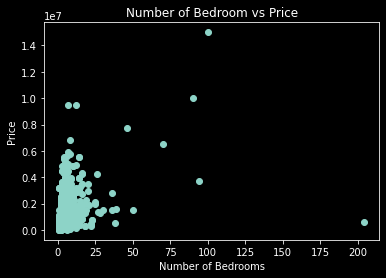

In [327]:
x = bedroom_dropna['Bedrooms']
y = bedroom_dropna['Price']
plt.scatter(x, y)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.title('Number of Bedroom vs Price')
plt.show()

## 14. Garden

In [328]:
houses.groupby(['Garden']).count().iloc[:,:1]

,Immoweb ID
Garden,
Yes,848


In [329]:
houses.loc[:, 'Garden']

0      NaN
3      NaN
4      NaN
5      NaN
6      NaN
      ... 
469    NaN
486    NaN
489    NaN
491    NaN
492    NaN
Name: Garden, Length: 8747, dtype: object

In [330]:
gar_uniq = houses['Garden'].unique()
gar_uniq

array([nan, 'Yes'], dtype=object)

In [331]:
houses.Garden.isnull().sum()

7899

In [332]:
houses.Garden.isnull().sum()*100/len(houses)

90.30524751343317

The percentage of missing value is 90%, it is quite high

In [333]:
print(houses['Garden'].isnull().sum())
print(houses['Garden surface'].isnull().sum())

houses['Garden'] = houses['Garden'].fillna(houses['Garden surface'].notnull())

7899
6656


Although there are missing values in Garden column there are values in the related index of Garden surface column. Therefore I filled these data points as binary value according to Garden surface column.

In [334]:
def garden_conv(value : str) -> int:
    if value == False: 
        return 0
    elif value == True:
        return 1

houses['Garden'] = houses['Garden'].apply(garden_conv)
houses['Garden'].unique()

array([ 0.,  1., nan])

## 15. Garden Surface

In [335]:
houses.groupby(['Garden surface']).count().iloc[:, -1]

Garden surface
1        0
10       0
100      0
1000     0
10000    0
        ..
985      0
99       0
990      0
991      0
997      0
Name: Date of the sale, Length: 630, dtype: int64

In [336]:
houses['Garden surface'].isnull().sum()

6656

The percentage of missing value is 77.66

## THE FINAL RESULT

In [337]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 0 to 492
Columns: 112 entries, Immoweb ID to Date of the sale
dtypes: float64(8), int64(4), object(100)
memory usage: 7.5+ MB


Pearson Method

The method gives information about the correlation, as well as the direction of the relationship between two continous variables



In [338]:
a = houses.corr(method = 'spearman', min_periods = 1)
a


,Property type,Price,Eur/m2,Extra,Building condition,Living area,Kitchen type,Energy class,Double glazing,Swimming pool,Garden,Surface of the plot
Property type,1.000000,0.408049,-0.438960,NaN,-0.288569,0.682747,-0.128250,-0.252512,0.033373,0.285247,0.256189,NaN
Price,0.408049,1.000000,0.213465,0.509552,0.140485,0.750613,0.218501,0.093548,0.047464,0.312875,0.145234,0.363192
Eur/m2,-0.438960,0.213465,1.000000,0.310110,0.362088,-0.404978,0.244526,0.213331,-0.019433,-0.018140,-0.101446,0.135638
Extra,NaN,0.509552,0.310110,1.000000,0.405861,0.399165,0.640148,0.572573,0.169639,0.734919,0.014087,0.443012
Building condition,-0.288569,0.140485,0.362088,0.405861,1.000000,-0.124076,0.334614,0.444497,0.056645,0.033963,-0.013448,0.119498
Living area,0.682747,0.750613,-0.404978,0.399165,-0.124076,1.000000,0.029144,-0.062617,0.038745,0.339062,0.191199,0.330659
Kitchen type,-0.128250,0.218501,0.244526,0.640148,0.334614,0.029144,1.000000,0.177811,0.085213,0.072778,0.008195,0.079885
Energy class,-0.252512,0.093548,0.213331,0.572573,0.444497,-0.062617,0.177811,1.000000,0.018320,0.099792,-0.062019,0.073099
Double glazing,0.033373,0.047464,-0.019433,0.169639,0.056645,0.038745,0.085213,0.018320,1.000000,0.074650,0.064485,-0.014017
Swimming pool,0.285247,0.312875,-0.018140,0.734919,0.033963,0.339062,0.072778,0.099792,0.074650,1.000000,0.083228,0.458628


In [339]:
a['Price'].sort_values(ascending = False)

Price                  1.000000
Living area            0.750613
Extra                  0.509552
Property type          0.408049
Surface of the plot    0.363192
Swimming pool          0.312875
Kitchen type           0.218501
Eur/m2                 0.213465
Garden                 0.145234
Building condition     0.140485
Energy class           0.093548
Double glazing         0.047464
Name: Price, dtype: float64

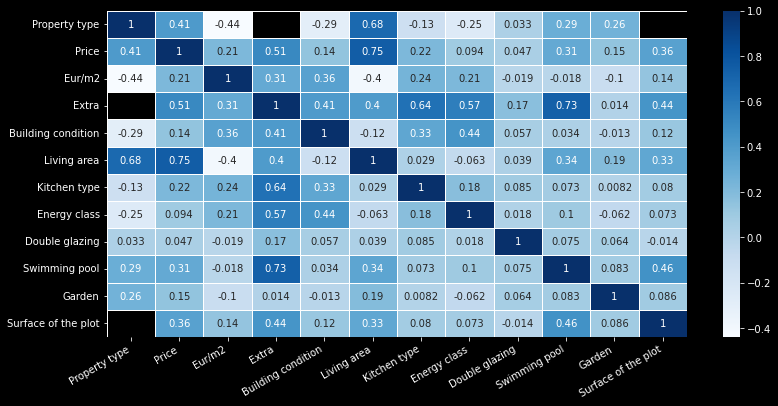

In [340]:
plt.figure(figsize=(13, 6))
sns.heatmap(a, vmax=1, annot=True, linewidths=.5,  cmap="Blues")
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()




Text(0, 0.5, 'Price')

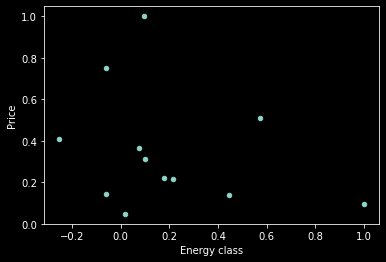

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
ax = a.plot.scatter(x='Energy class', y='Price', sharex=False)
ax.set_xlabel('Energy class')
ax.set_ylabel('Price')

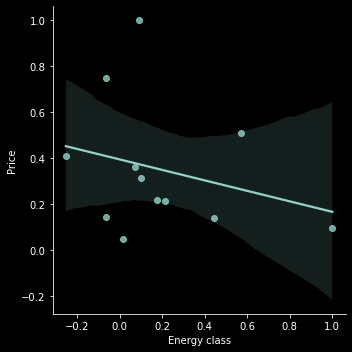

In [342]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Energy class', y='Price', data=a)


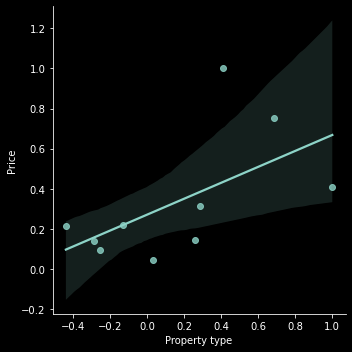

In [343]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Property type', y='Price', data=a)

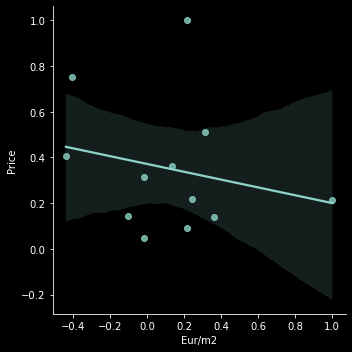

In [344]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Eur/m2', y='Price', data=a)

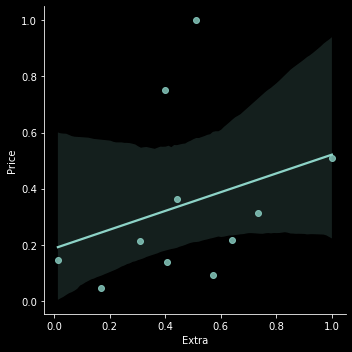

In [345]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Extra', y='Price', data=a)

In [346]:
"""import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Municipality', y='Price', data=a)"""



"import seaborn as sns\nplt.style.use('dark_background')\nax = sns.lmplot(x='Municipality', y='Price', data=a)"

In [347]:
"""import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Construction year', y='Price', data=a)"""

"import seaborn as sns\nplt.style.use('dark_background')\nax = sns.lmplot(x='Construction year', y='Price', data=a)"

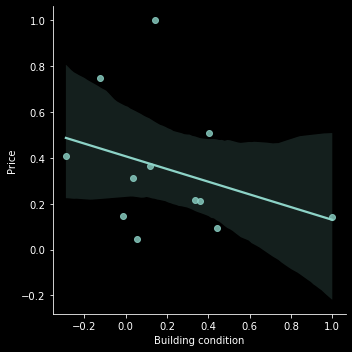

In [348]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Building condition', y='Price', data=a)

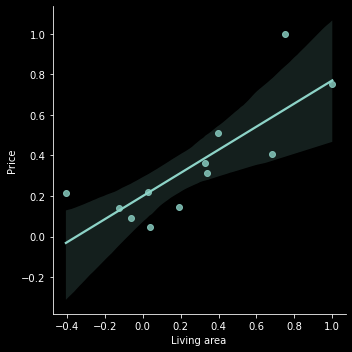

In [349]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Living area', y='Price', data=a)

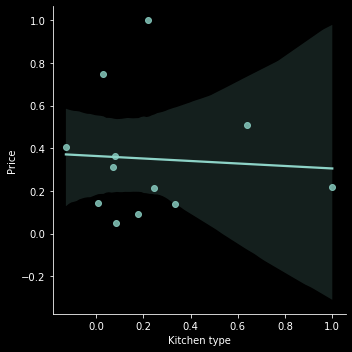

In [350]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Kitchen type', y='Price', data=a)

In [351]:
"""import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Terrace surface', y='Price', data=a)"""

"import seaborn as sns\nplt.style.use('dark_background')\nax = sns.lmplot(x='Terrace surface', y='Price', data=a)"

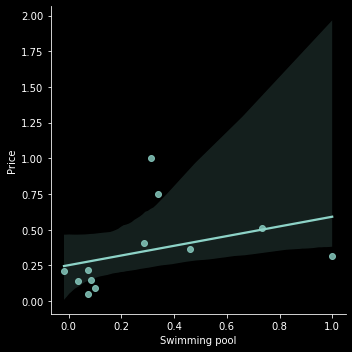

In [352]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Swimming pool', y='Price', data=a)

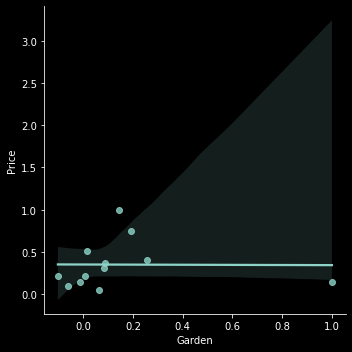

In [353]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Garden', y='Price', data=a)

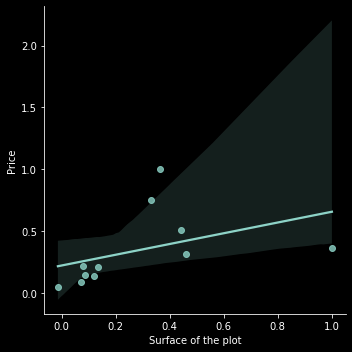

In [354]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Surface of the plot', y='Price', data=a)

Spearman Method

The method determines the strength and direction of the monotonic relationship between two variables. A monotonic relationship is a relationship that does one of the following: (1) as the value of one variable increases, so does the value of the other variable; or (2) as the value of one variable increases, the other variable value decreases

In [355]:
b = houses.corr(method='spearman')


## Municipality

In [356]:
houses = houses.rename(columns={"Tenement building" : "Municipality"})
mylist = []

for elem in houses["url address"]:
    name = elem.split("/")
    mylist.append(name[7])

houses["Municipality"] = mylist

In [357]:
houses['Municipality']

0              haren-(bru.)
3      woluwe-saint-lambert
4                    forest
5                   ixelles
6                     evere
               ...         
469          geraardsbergen
486            sint-niklaas
489                    gent
491                oostende
492                  aalter
Name: Municipality, Length: 8747, dtype: object

### Changing the datatype of Post code

In [358]:
houses['Post code'] = houses['Post code'].astype(int)

In [359]:
houses = houses.rename(columns={"Heating type":"Region"})
for x in houses:
    if x == "Post code":
        for code in houses[x]:
            if code >= 9000 and code <= 9999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 1000 and code <= 1299:
                houses.loc[houses["Post code"] == code, "Region"] = "Brussels"
            if code >= 1300 and code <= 1499:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 1500 and code <= 1999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 2000 and code <= 2999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 3000 and code <= 3499:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 3500 and code <= 3999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 4000 and code <= 4999:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 5000 and code <= 5999:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 6000 and code <= 6599:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 6600 and code <= 6999:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 7000 and code <= 7999:
                houses.loc[houses["Post code"] == code, "Region"] = "Wallonia"
            if code >= 8000 and code <= 8999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"
            if code >= 9000 and code <= 9999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flanders"

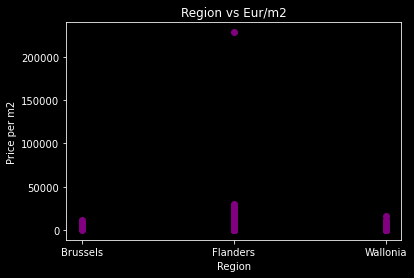

In [360]:
x = houses['Region']
y = houses['Eur/m2']
plt.scatter(x, y, c='purple')
plt.xlabel('Region')
plt.ylabel('Price per m2')
plt.title('Region vs Eur/m2')
plt.show()

In [361]:
houses['Immoweb ID'].count()



8747

In [362]:
houses['Region']


0      Brussels
3      Brussels
4      Brussels
5      Brussels
6      Brussels
         ...   
469    Flanders
486    Flanders
489    Flanders
491    Flanders
492    Flanders
Name: Region, Length: 8747, dtype: object

In [363]:
houses = houses[['Immoweb ID', 'Property type', 'property sub-type', 'Price', 'Extra', 'Post code', 'Construction year', 'Municipality', 'Region']] 


In [364]:
houses.head()

,Immoweb ID,Property type,property sub-type,Price,Extra,Post code,Construction year,Municipality,Region
0,9739983,1,PENTHOUSE,476000,NaN,1130,2017,haren-(bru.),Brussels
3,9737424,1,PENTHOUSE,399000,NaN,1200,1992,woluwe-saint-lambert,Brussels
4,9737272,1,PENTHOUSE,499000,NaN,1190,2018,forest,Brussels
5,9737235,1,PENTHOUSE,1495000,NaN,1050,2019,ixelles,Brussels
6,9729720,1,PENTHOUSE,179000,NaN,1140,1970,evere,Brussels


In [378]:
  
houses.to_csv('./data/clean_house_data.csv')



FileNotFoundError: [Errno 2] No such file or directory: './final_data/clean_house_data.csv'